In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

In [2]:
# CONSTANTS
SIZE = ((25, 10))
SAMPLES_NUM = 800
START_DATE = datetime(2020, 3, 3)
GRAPH_LEGEND_SIZE = 15
DAYS_IN_MAY = (datetime(2020,5,1) - START_DATE).days
DAYS_IN_JUN = (datetime(2020,6,1) - START_DATE).days
DAYS_IN_SEP = (datetime(2020,9,1) - START_DATE).days
MAX_PTS_FOR_HIST = 3000000

In [3]:
!pip install wget
import wget

1) Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [4]:
# скачиваем и читаем датасет
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
filename = wget.download(url)

-1 / unknown

In [5]:
df = pd.read_csv(filename)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

In [6]:
# берем из общего df кусок с данными по России
rus_df = df.loc[df['location'] == "Russia"]
rus_df.loc[rus_df["new_cases"] == 0, "new_cases"] = 1
rus_df = rus_df.loc[rus_df['date'] >= START_DATE]
rus_df['day_num'] = range(1, len(rus_df) + 1)
train_rus_df = rus_df.loc[rus_df['date'] < START_DATE + timedelta(days=50)]
test_rus_df = rus_df.loc[rus_df['date'] >= START_DATE + timedelta(days=50)]

D:\Program Files\Anaconda\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


2 Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально
Для первого подхода к снаряду давайте это и используем.

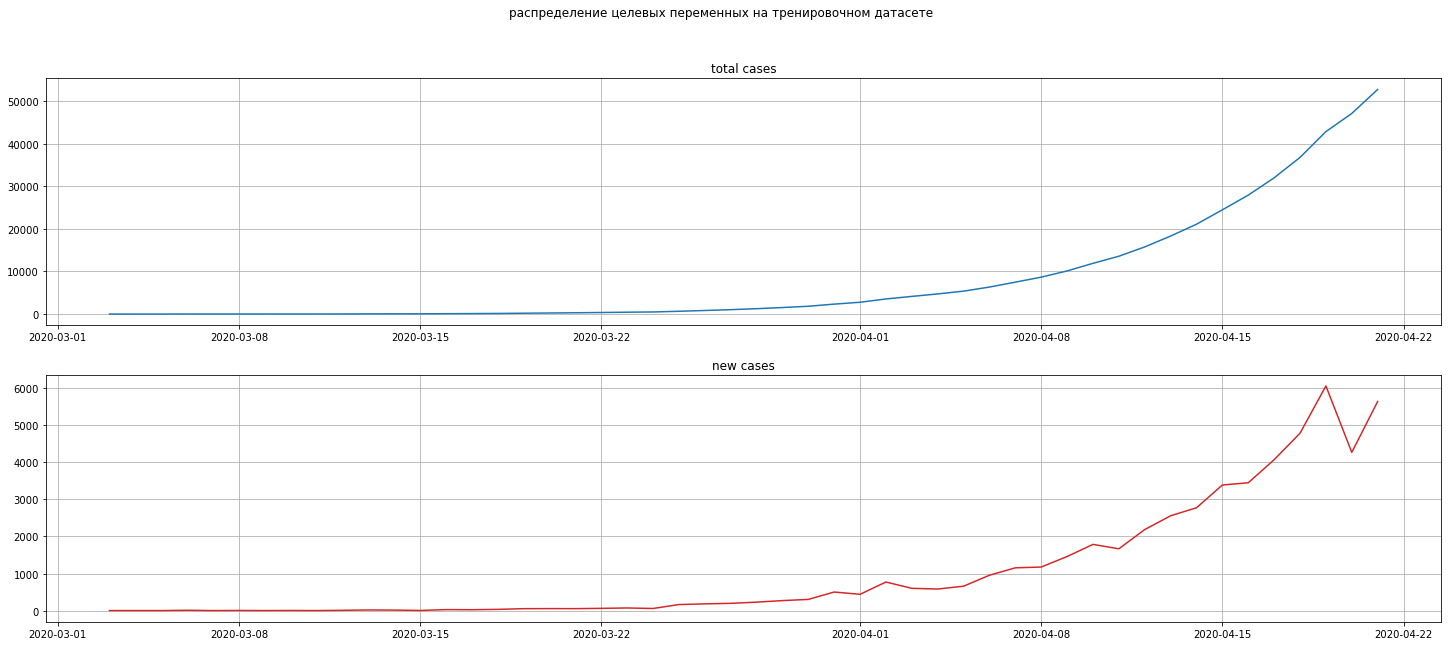

In [7]:
# построим графики для тренировочного датасета
fig, axs = plt.subplots(2, figsize=SIZE)
fig.suptitle("распределение целевых переменных на тренировочном датасете")
axs[0].set_title("total cases")
axs[0].grid(True)
axs[0].plot(train_rus_df["date"], train_rus_df["total_cases"])
axs[1].grid(True)
axs[1].set_title("new cases")
axs[1].plot(train_rus_df["date"],train_rus_df["new_cases"], 'tab:red')

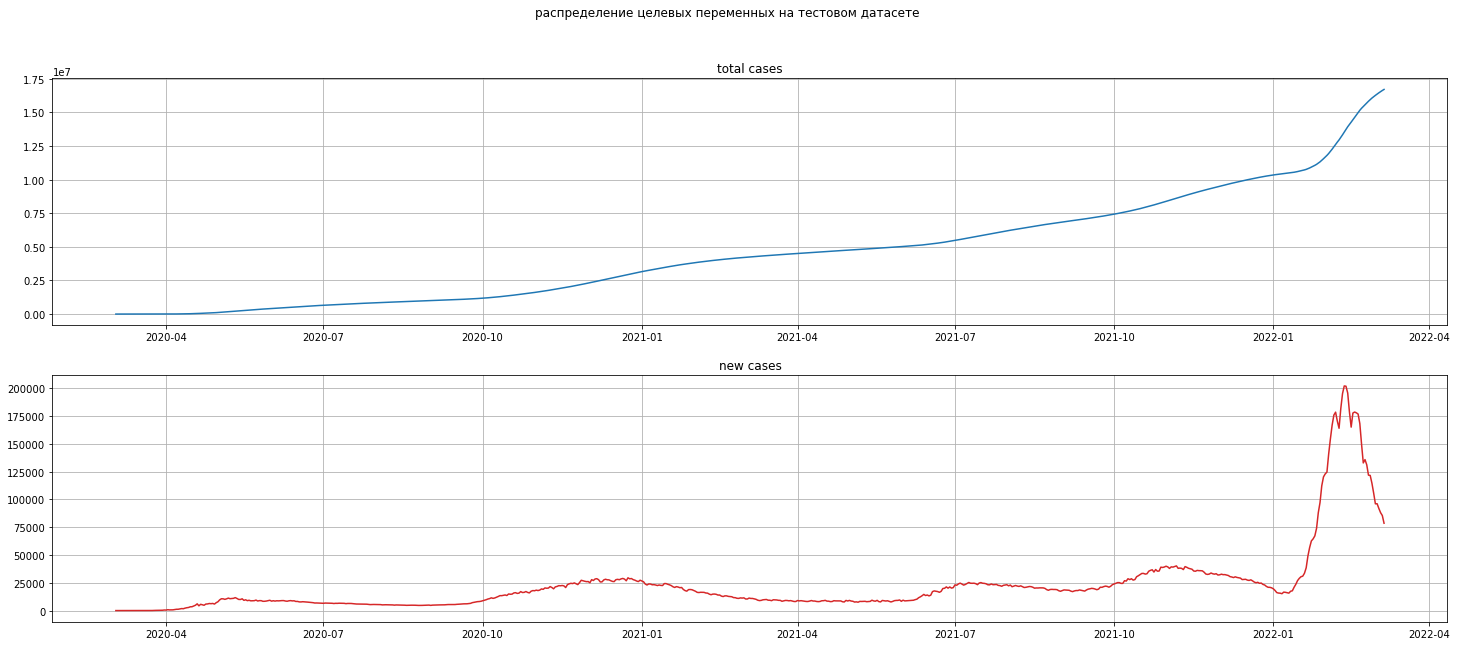

In [8]:
# и для тестового датасета
fig, axs = plt.subplots(2, figsize=SIZE)
fig.suptitle("распределение целевых переменных на тестовом датасете")
axs[0].set_title("total cases")
axs[0].grid(True)
axs[0].plot(rus_df["date"], rus_df["total_cases"])
axs[1].grid(True)
axs[1].set_title("new cases")
axs[1].plot(rus_df["date"], rus_df["new_cases"], 'tab:red')

2. a) Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

$$y \approx e^{(ax + b)} \Rightarrow ln(y) \approx ax + b$$

In [9]:
linear_model = LinearRegression()
linear_model.fit(train_rus_df['day_num'].values.reshape(-1, 1), np.log(train_rus_df['total_cases']))
preds = linear_model.predict(train_rus_df["day_num"].values.reshape(-1, 1))

In [10]:
preds

array([ 1.82073715,  2.01902806,  2.21731897,  2.41560989,  2.6139008 ,
        2.81219171,  3.01048262,  3.20877354,  3.40706445,  3.60535536,
        3.80364627,  4.00193718,  4.2002281 ,  4.39851901,  4.59680992,
        4.79510083,  4.99339175,  5.19168266,  5.38997357,  5.58826448,
        5.7865554 ,  5.98484631,  6.18313722,  6.38142813,  6.57971904,
        6.77800996,  6.97630087,  7.17459178,  7.37288269,  7.57117361,
        7.76946452,  7.96775543,  8.16604634,  8.36433726,  8.56262817,
        8.76091908,  8.95920999,  9.15750091,  9.35579182,  9.55408273,
        9.75237364,  9.95066455, 10.14895547, 10.34724638, 10.54553729,
       10.7438282 , 10.94211912, 11.14041003, 11.33870094, 11.53699185])

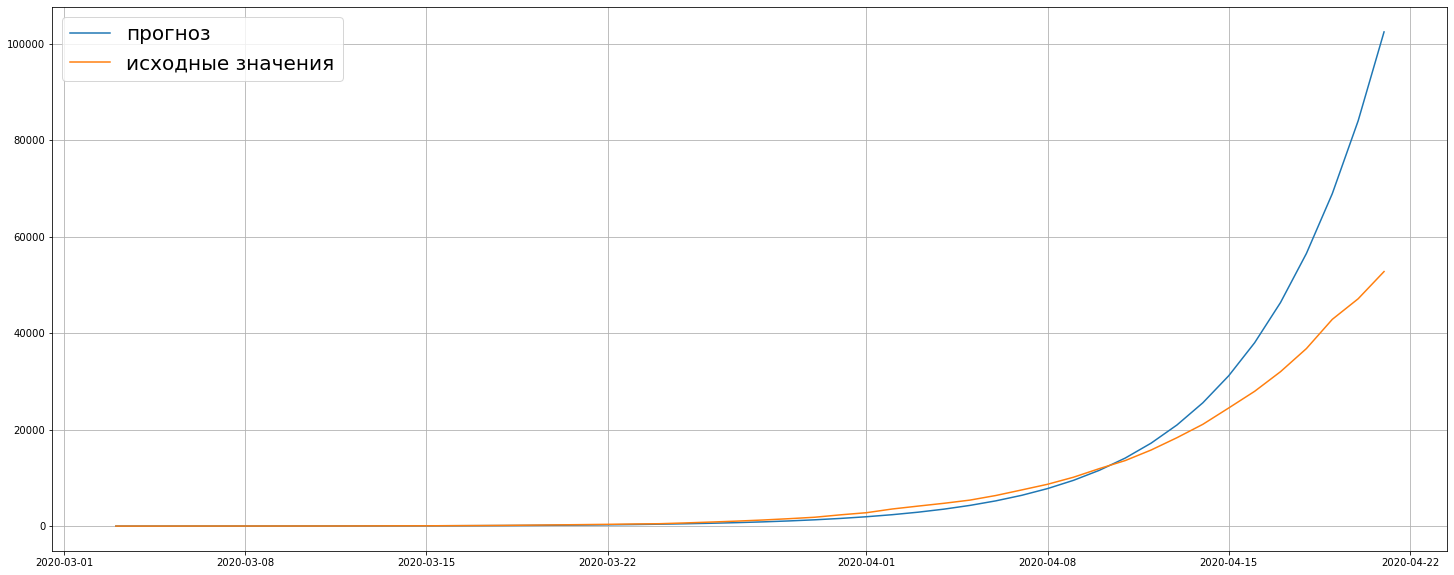

In [11]:
plt.figure(figsize=SIZE)
plt.grid(True)
plt.plot(train_rus_df["date"], np.exp(preds), label='прогноз')
plt.plot(train_rus_df["date"], train_rus_df["total_cases"], label='исходные значения')
plt.legend(fontsize=20)

2) b. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

Начнем с дисперсии. Формула для нахождения квадрата дисперсии выглядит следующим образом: \
$$\sigma^2  = \frac {1}{N}\sum\limits_{i=1}^N({y_n -\bar w^T\phi(x_n))^2 },$$
где:
$y_n$ - таргетные значения, \
$\bar w^T\phi(x_n)$ - прогноз

In [12]:
# не забываем, что берем логарифм от таргета
sigma_sq = np.mean((np.log(train_rus_df["total_cases"]) - preds)**2)
sigma_sq

0.1218304615439124

In [13]:
# функция для апдейта сигмы и мю
def update_sigma_mu(mu_0, sigma_0, x, target, sigma_sq):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma_0)+ (1 / sigma_sq) * np.dot(np.transpose(x), x))
    mu_n = sigma_n.dot(np.linalg.inv(sigma_0).dot(mu_0) + (1 / sigma_sq) * np.dot(np.transpose(x), target))
    return sigma_n, mu_n

In [14]:
mu_0, sigma_0 = np.array([0, 0]), 1000 * np.array([[1, 0], [0, 1]])
x = np.column_stack([np.ones(train_rus_df.shape[0]), train_rus_df["day_num"]])
sigma, mu = update_sigma_mu(mu_0, sigma_0, x, np.log(train_rus_df["total_cases"]).values, sigma_sq)
print(f"sigma={sigma}, mu={mu}")

sigma=[[ 1.00446963e-02 -2.98357314e-04]
 [-2.98357314e-04  1.17003153e-05]], mu=[1.62243    0.19829139]


2) c. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [15]:
samples = np.random.multivariate_normal(mu, sigma, SAMPLES_NUM)
targets = [np.exp(sample[0] + train_rus_df['day_num'].values * sample[1])   for sample in samples]

Text(0, 0.5, 'num of cases')

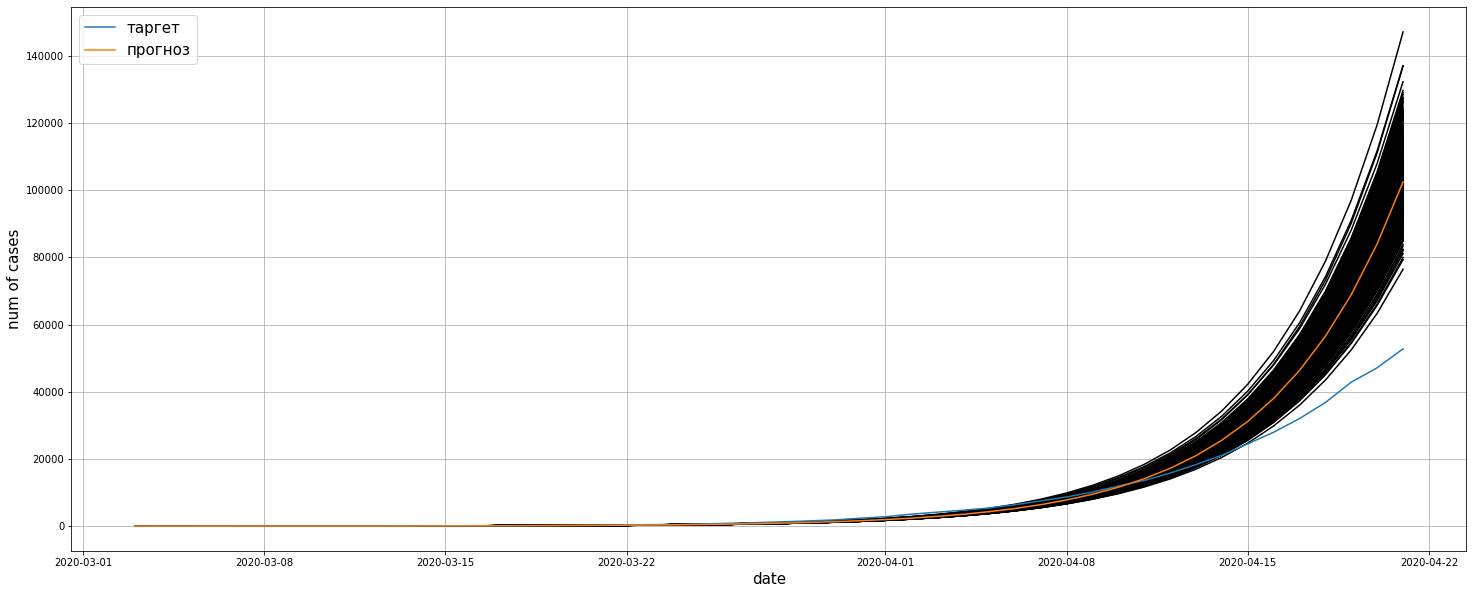

In [16]:
plt.figure(figsize=SIZE)
for n in range(SAMPLES_NUM):
    plt.plot(train_rus_df["date"], targets[n], color="black")

plt.plot(train_rus_df["date"], train_rus_df['total_cases'], label='таргет')
plt.plot(train_rus_df["date"], np.exp(preds), label='прогноз')

plt.legend(fontsize=GRAPH_LEGEND_SIZE)
plt.grid(True)
plt.xlabel('date', fontsize=GRAPH_LEGEND_SIZE)
plt.ylabel('num of cases', fontsize=GRAPH_LEGEND_SIZE)

In [17]:
def get_preds_by_day(days):
    days_arr = np.array([1, days])
    preds = np.exp(samples.dot(days_arr.T))
    return preds

In [18]:
def plot_hist(preds, month):
    plt.figure(figsize=SIZE)
    plt.grid(True)
    plt.hist(preds,  bins=50)
    plt.xlabel("Количество заражений")
    plt.ylabel("Количество семплов")
    plt.title(f"Предсказания на 1 {month}");

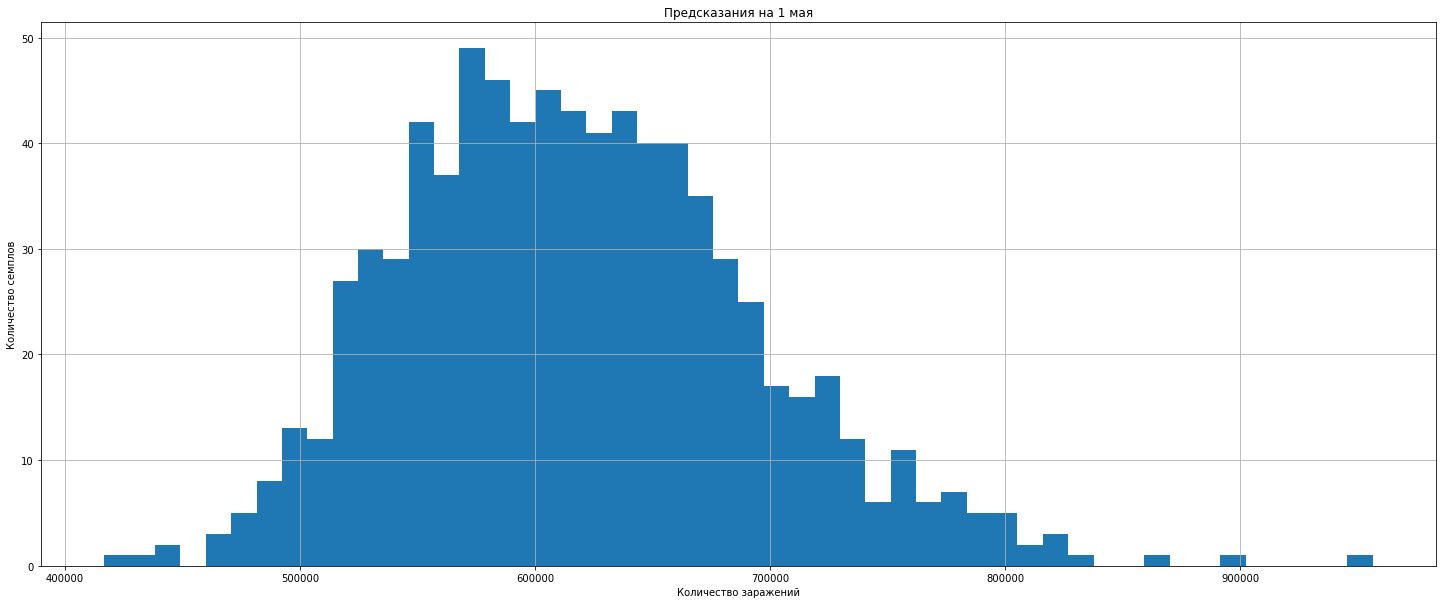

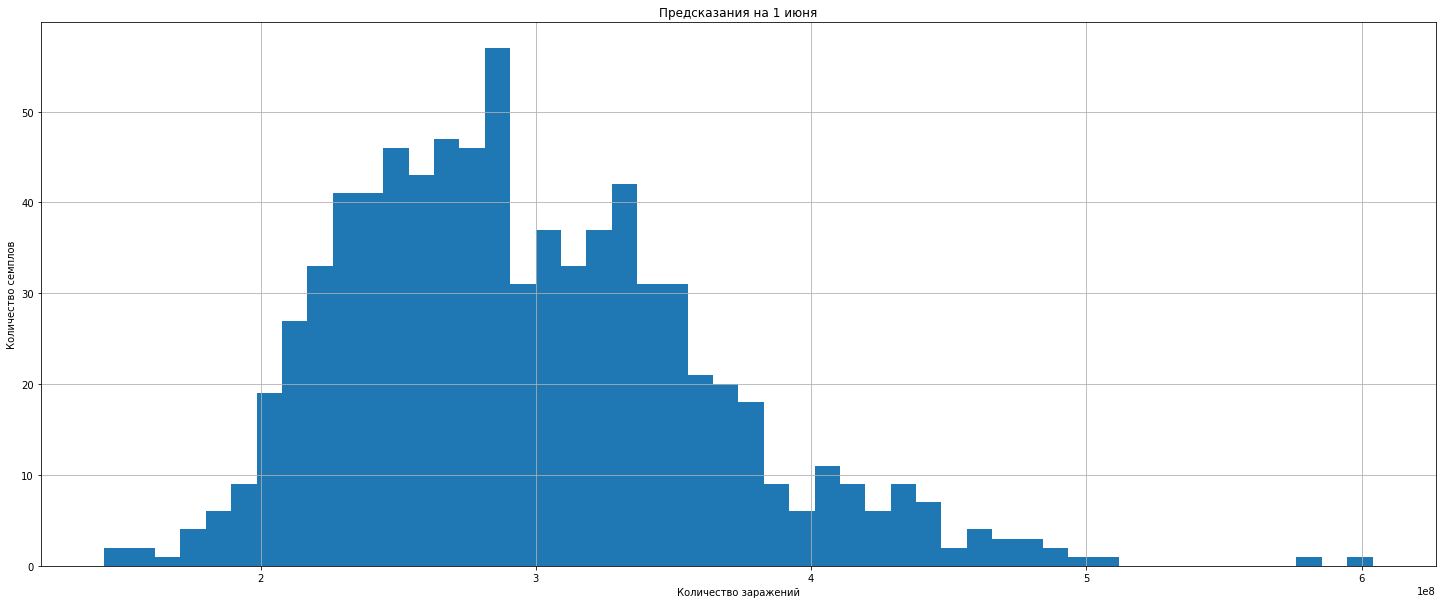

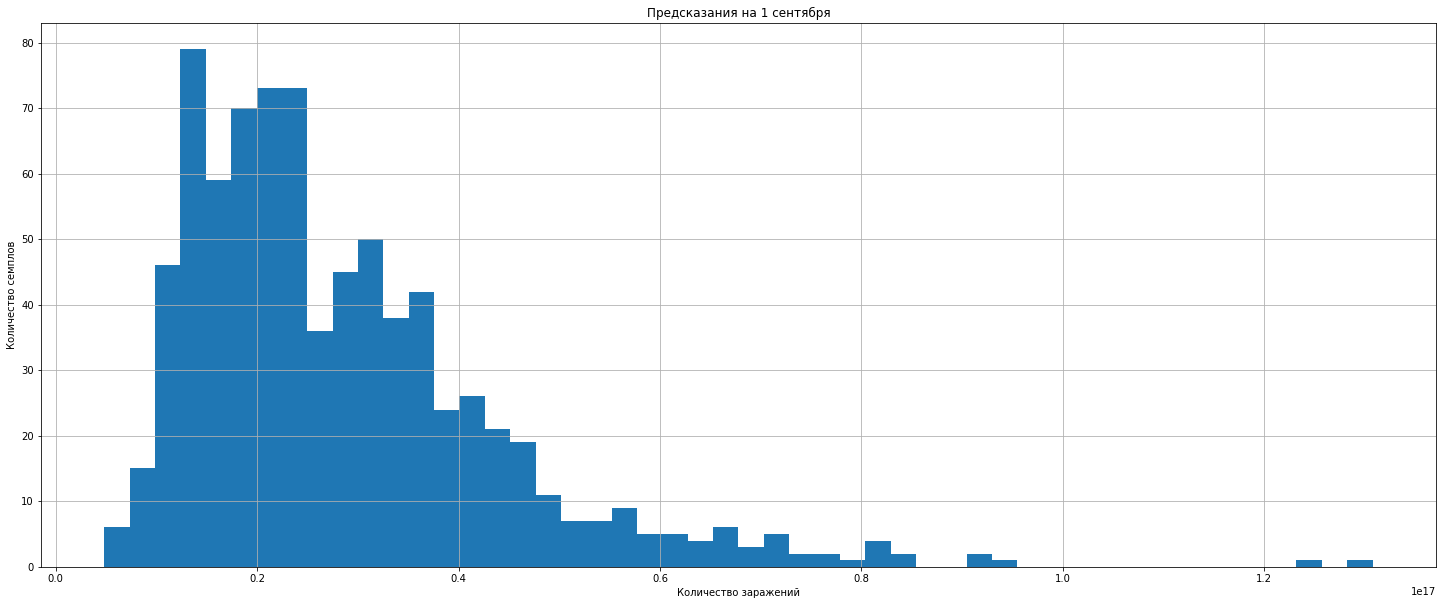

In [19]:
plot_hist(get_preds_by_day(DAYS_IN_MAY), "мая")
plot_hist(get_preds_by_day(DAYS_IN_JUN), "июня")
plot_hist(get_preds_by_day(DAYS_IN_SEP), "сентября")

In [20]:
preds = np.exp(linear_model.predict(np.array([DAYS_IN_MAY, DAYS_IN_JUN, DAYS_IN_SEP]).reshape(-1, 1)))
print(f"Заражений на 1 мая (млн): {preds[0] / 1000000}")
print(f"Заражений на 1 июня (млн): {preds[1] / 1000000}")
print(f"Заражений на 1 сентября (млн): {preds[2] / 1000000}")

Заражений на 1 мая (млн): 0.6102415029447825
Заражений на 1 июня (млн): 285.17920972746697
Заражений на 1 сентября (млн): 23869843564.137115


3) Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

$$\Phi=\frac{1}{2\pi}\int\limits_x^\infty e^{-t^2/2}dt$$
Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

3. a) Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Немного перепишем формулу:
$$y_{total\_cases}=\frac{1}{2\pi}\int\limits_x^\infty e^{-t^2/2}dt$$
Начнем с того, что перейдем от total_cases к new_cases. Для этого возьмем от предыдущей формулы производную:
$$(y_{total\_cases})' = e^{-t^2/2}$$
$y'- y_{new\_cases} $.Теперь избавимся от экспоненты:
$$ln(y_{new\_cases}) = -t^2/2$$
где t - произвольная функция.
Поэтому итоговую формулу, на мой взгляд, можно записать так:
$$ln(y_{new\_cases}) = at^2 + bt + c$$

3 b) Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.


In [21]:
X = np.column_stack([train_rus_df["day_num"], train_rus_df["day_num"] ** 2])
y = np.log(train_rus_df['new_cases'].values)
model = LinearRegression()
model.fit (X, y)
preds = model.predict(X)

Text(0, 0.5, 'num of cases')

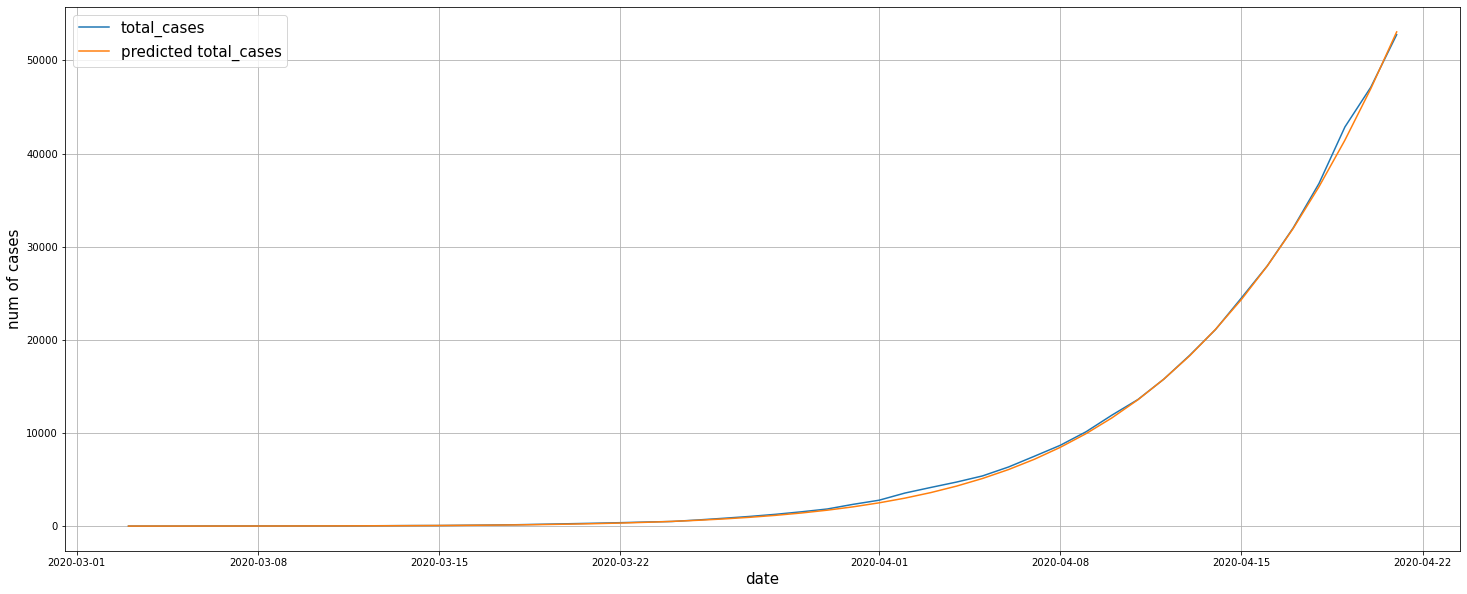

In [22]:
plt.figure(figsize=SIZE)
plt.plot(train_rus_df['date'], train_rus_df['total_cases'], label='total_cases')
plt.plot(train_rus_df['date'], np.exp(preds).cumsum(), label='predicted total_cases')
plt.legend(fontsize=GRAPH_LEGEND_SIZE)
plt.grid(True)
plt.xlabel('date', fontsize=GRAPH_LEGEND_SIZE)
plt.ylabel('num of cases', fontsize=GRAPH_LEGEND_SIZE)

In [23]:
sig_square = np.mean((y - preds)**2)
sig_square

0.23928684127005564

In [24]:
X = np.column_stack([np.ones_like(train_rus_df["day_num"]), X])
mu_0, sigma_0 = np.array([0, 0, 0]), 1000 * np.array([[1, 0, 0],[0, 1, 0], [0, 0, 1]])
sigma, mu = update_sigma_mu(mu_0, sigma_0, X, y, sigma_sq)
print(f"mu = {mu};\n sigma = {sigma}")

mu = [-0.67402647  0.27928109 -0.00182977];
 sigma = [[ 2.37812343e-02 -1.88335433e-03  3.10784535e-05]
 [-1.88335433e-03  1.94585954e-04 -3.58600223e-06]
 [ 3.10784535e-05 -3.58600223e-06  7.03139520e-08]]


3 с) Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [25]:
samples = np.random.multivariate_normal(mu, sigma, SAMPLES_NUM)
targets = [np.exp(sample[0] + train_rus_df['day_num'].values * sample[1])   for sample in samples]

Text(0, 0.5, 'num of cases')

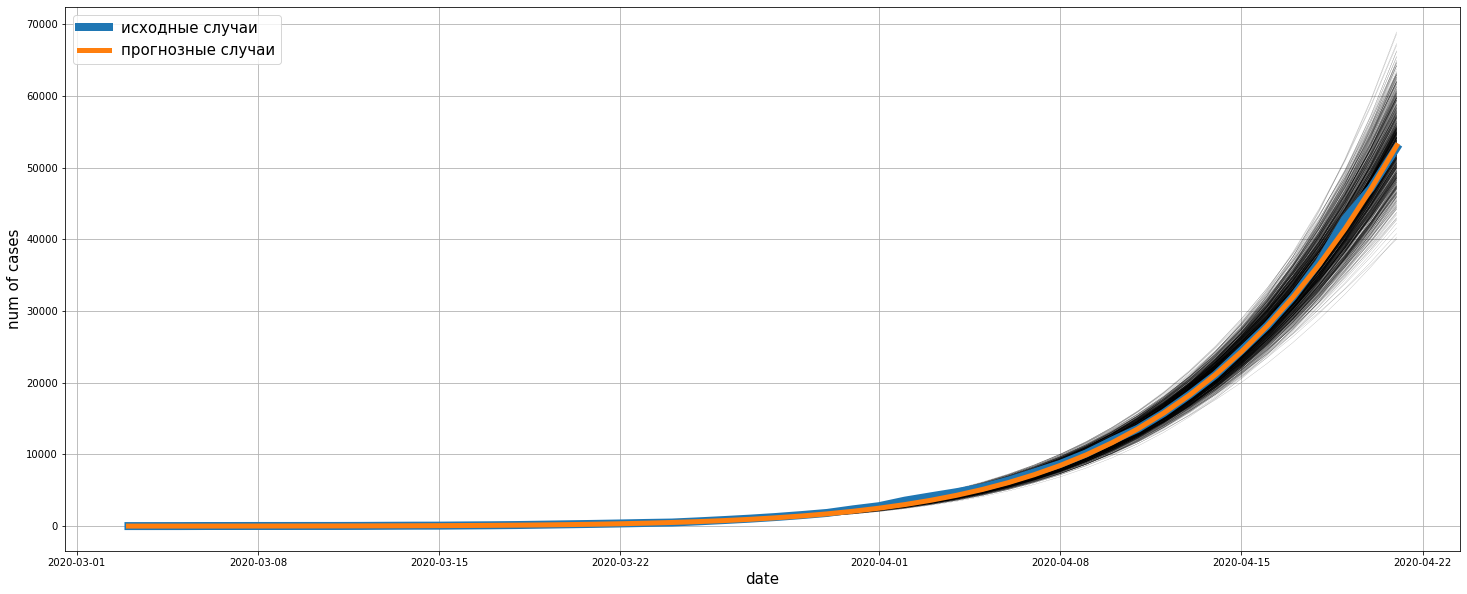

In [26]:
plt.figure(figsize=SIZE)
gen_targ = [ np.exp(X.dot(samples[i])).cumsum() for i in range(SAMPLES_NUM)]
for i in range(SAMPLES_NUM):
    plt.plot(train_rus_df["date"], gen_targ[i], color="black", linewidth=.1)

plt.plot(train_rus_df["date"], train_rus_df['total_cases'], label='исходные случаи', linewidth = 8)
plt.plot(train_rus_df["date"], np.exp(preds).cumsum(), label='прогнозные случаи', linewidth = 5)

plt.legend(fontsize=GRAPH_LEGEND_SIZE)
plt.grid(True)
plt.xlabel('date', fontsize=GRAPH_LEGEND_SIZE)
plt.ylabel('num of cases', fontsize=GRAPH_LEGEND_SIZE)

Text(0, 0.5, 'num of cases')

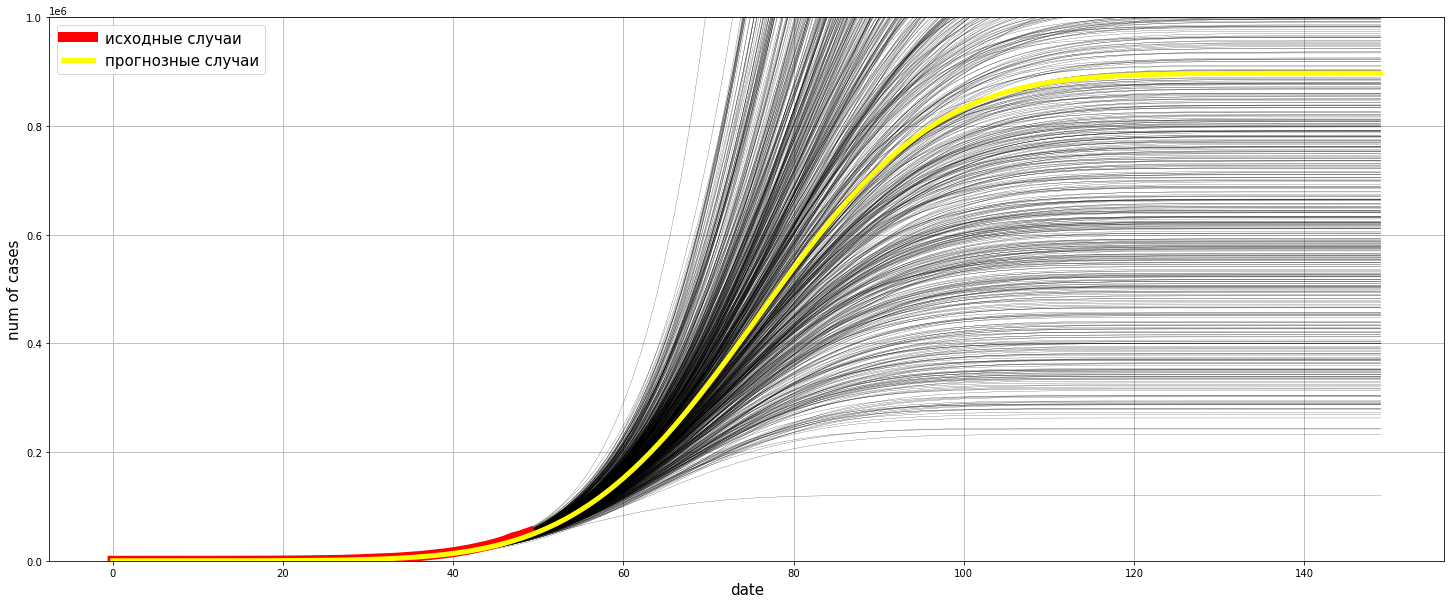

In [27]:
days_for_pred = np.arange(150)
samples2 = np.random.multivariate_normal(mu, sigma, SAMPLES_NUM)

x_pred = np.column_stack([days_for_pred, days_for_pred ** 2])
x_add_samp = np.column_stack([np.ones(days_for_pred.shape[0]), days_for_pred, days_for_pred ** 2])
cumsum_add = [np.exp(x_add_samp.dot(samples2[i])).cumsum() for i in range(SAMPLES_NUM)]
preds2 = model.predict(x_pred)
plt.figure(figsize=SIZE)
plt.grid(True)
for i in range(SAMPLES_NUM):
    plt.plot(days_for_pred, cumsum_add[i], color="black", linewidth=0.2)
    
plt.plot(np.arange(50), train_rus_df['total_cases'].values, label='исходные случаи', color="red", linewidth = 10)
plt.plot(days_for_pred, np.exp(preds2).cumsum(), label='прогнозные случаи', color="yellow", linewidth = 5)
plt.ylim(0, 1_000_000)
plt.legend(fontsize=GRAPH_LEGEND_SIZE)
plt.xlabel('date', fontsize=GRAPH_LEGEND_SIZE)
plt.ylabel('num of cases', fontsize=GRAPH_LEGEND_SIZE)

In [28]:
tmp = np.arange(DAYS_IN_SEP)
x_days = np.column_stack([np.ones(tmp.shape[0]), tmp, tmp ** 2])
preds = np.exp(samples.dot(x_days.T)).cumsum(1)
#print(preds.shape)


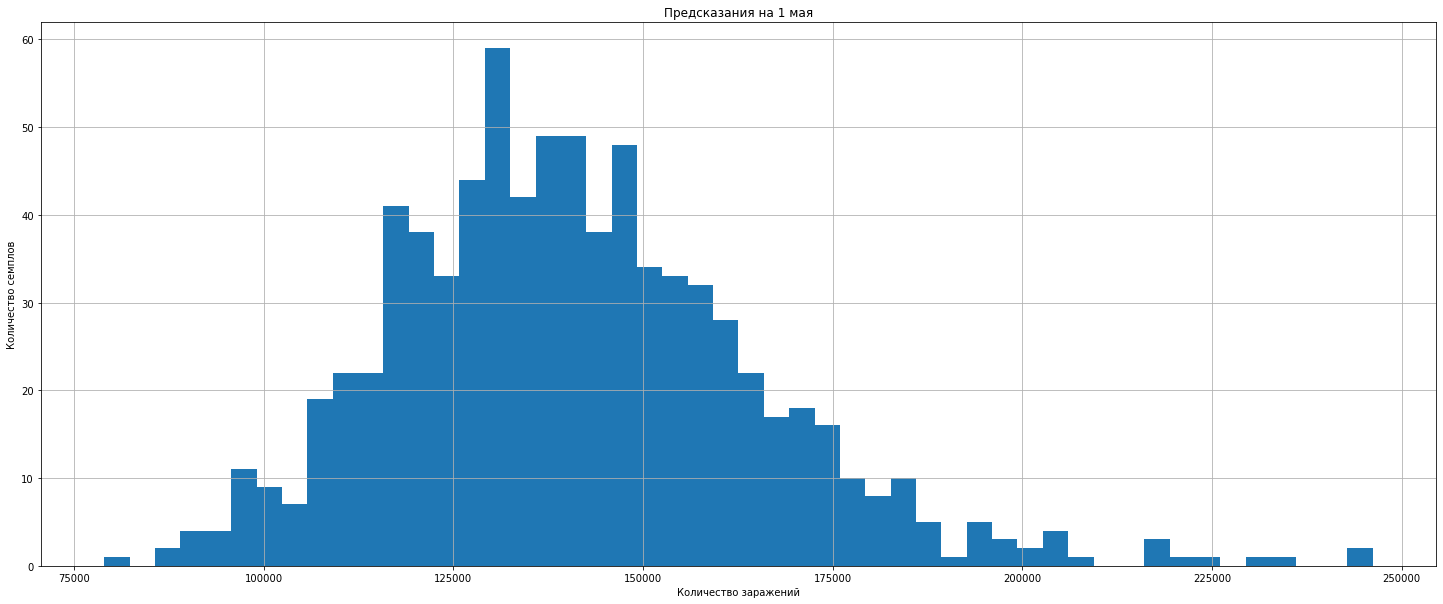

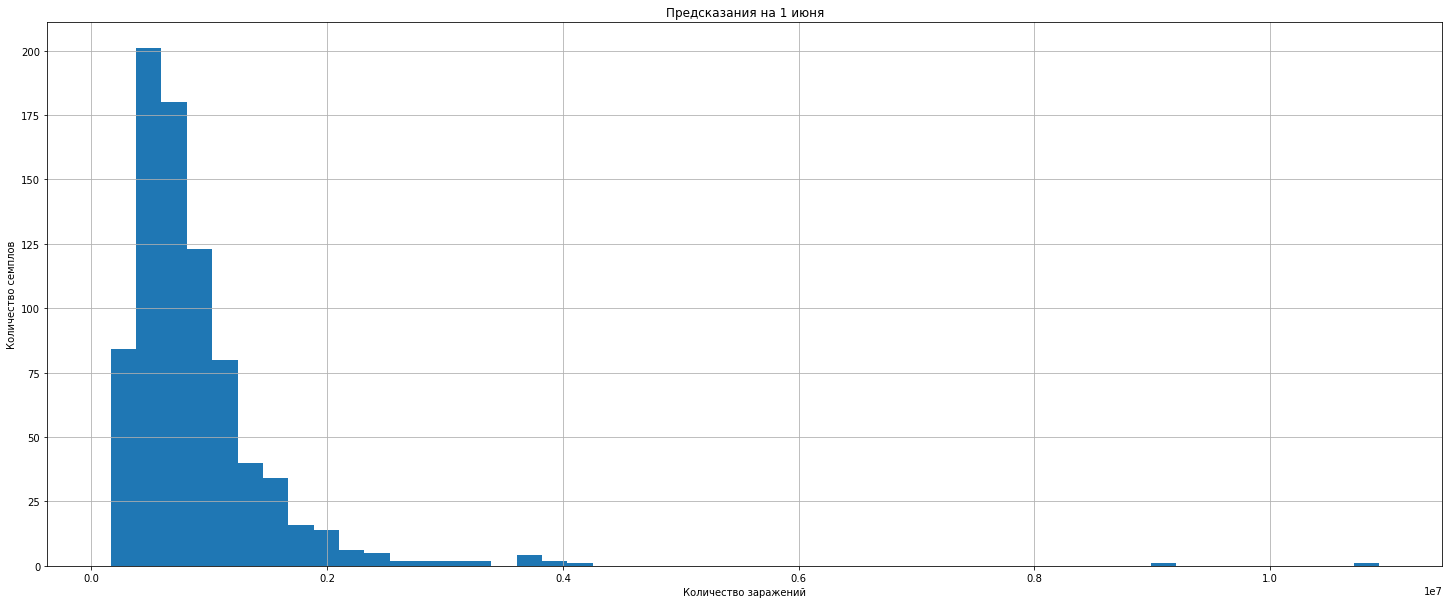

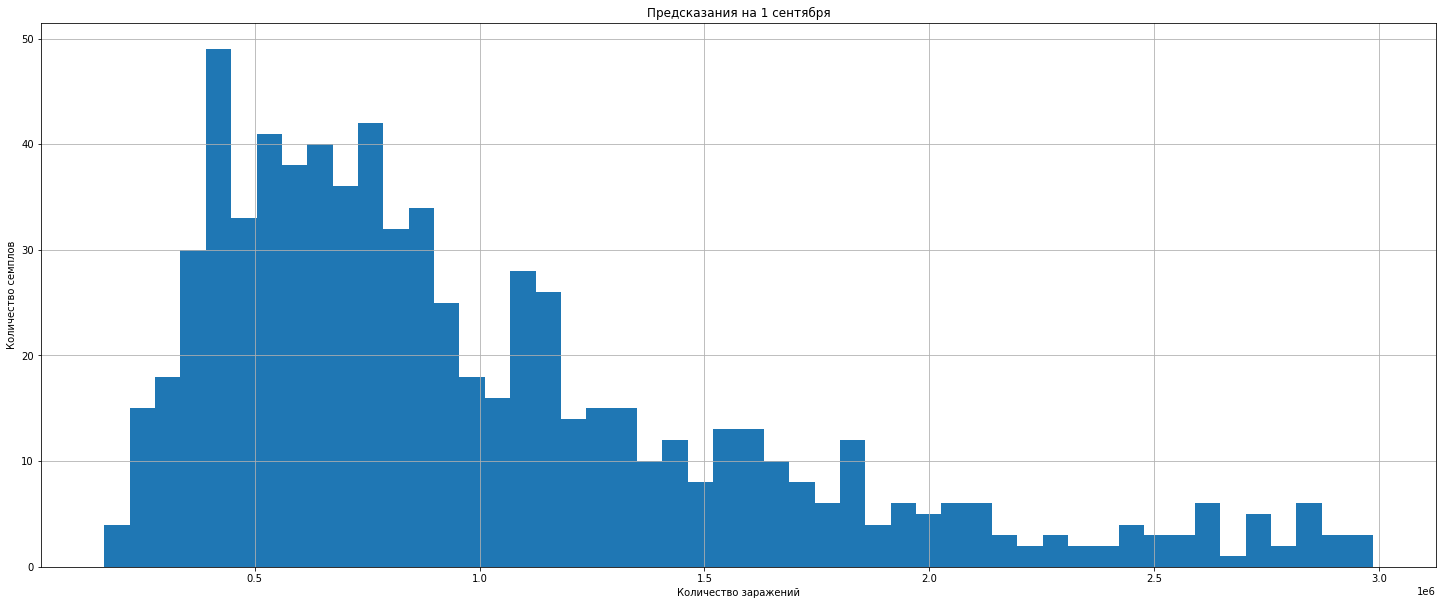

In [29]:
plot_hist(preds[:, DAYS_IN_MAY], "мая")
plot_hist(preds[:, DAYS_IN_JUN], "июня")
plot_hist(preds[:, DAYS_IN_SEP - 1][preds[:, DAYS_IN_SEP - 1] < MAX_PTS_FOR_HIST], "сентября")

Для финального прогноза по общему числу заболевших будем рассматривать сразу весь временной промежуток.

In [30]:
rus_df = rus_df['total_cases'].reset_index(drop=True)
x_sep = np.column_stack([tmp, tmp ** 2])
preds_sep = np.exp(model.predict(x_sep)).sum()

print(f'Наилучший прогноз (млн): {int(np.quantile(preds[:, -1], 0.1)) / 1000000}')
print(f'Наихудший прогноз (млн): {int(np.quantile(preds[:, -1], 0.9)) / 1000000}')
print(f'Зараженных по данным (млн): { rus_df[DAYS_IN_SEP] / 1000_000}')
print(f'Прогноз зараженных (млн): { preds_sep / 1000000}')

Наилучший прогноз (млн): 0.405335
Наихудший прогноз (млн): 2.735746
Зараженных по данным (млн): 0.997072
Прогноз зараженных (млн): 0.8970545270955418
